# Library

In [410]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Data Preparation

In [502]:
df = pd.read_csv("Bank_Churn_Modelling.csv")

In [503]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


In [504]:
df.shape

(10000, 14)

In [505]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           9997 non-null   object 
 6   Age              9997 non-null   float64
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Insights

Dapat dilihat pada kolom `Gender`, bahwa nilai unik pada kolom tersebut sebanyak 4 yang seharusnya terdapat 2. Maka perlu dilakukan penyesuaian categorical values pada kolom `Gender`.

In [506]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 4
Age                   74
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [507]:
df['Gender'].unique()

array(['Female', 'Male', 'M', 'F', nan], dtype=object)

In [508]:
# Mengganti nilai 'F' dengan 'Female' dan 'M' dengan 'Male'
df['Gender'] = df['Gender'].replace({'F': 'Female', 'M': 'Male'})

In [509]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   74
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

### Insights

Saya memutuskan untuk tidak menggunakan dua atribut pertama, yaitu `RowNumber` dan `CustomerID` karena atribut-atribut ini bersifat khusus untuk pelanggan dan tidak memiliki pengaruh langsung terhadap prediksi. Selain itu, atribut `Surname`, yang merupakan akhiran nama atau marga juga dihapus karena tidak memberikan informasi yang relevan untuk analisis dan dapat menyebabkan bias dalam pembuatan model. Oleh karena itu, atribut-atribut tersebut tidak akan digunakan untuk modeling.

In [510]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [511]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


### Insights

Pada kasus ini, variabel yang akan berperan sebagai variabel independen (X) yaitu variabel `CreditScore`, `Geography`, `Gender`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `HasCrCard`, `IsActiveMember`, dan `EstimatedSalary`. Sedangkan variabel `Exited` berperan sebagai variabel dependen.

In [512]:
# DMendeklarasikan variabel X dan y
X = df.drop(columns='Exited')
y = df['Exited']

In [513]:
print(f'Count of X: {X.shape}\ncount of y: {y.shape}')

Count of X: (10000, 10)
count of y: (10000,)


In [514]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           9997 non-null   object 
 3   Age              9997 non-null   float64
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


In [515]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: Exited
Non-Null Count  Dtype
--------------  -----
10000 non-null  int64
dtypes: int64(1)
memory usage: 78.3 KB


# Exploratory Data Analysis (EDA)

In [516]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

### Insights 

Data kategorikal pada kolom `Geography` dan `Gender` masih memiliki tipe data object dan harus diubah menjadi numerik. Pada kasus ini saya menggunakan fungsi `LabelEncoder()` untuk untuk mengonversi nilai-nilai kategorikal menjadi angka. `LabelEncoder()` bekerja dengan memberikan label numerik unik untuk setiap kategori dalam kolom, sehingga memungkinkan model machine learning untuk memproses data secara lebih efektif.

In [517]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           9997 non-null   object 
 3   Age              9997 non-null   float64
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [518]:
# Encoding untuk kolom Geography dan Gender
le = LabelEncoder()

# Encode kolom Geography
df['Geography'] = le.fit_transform(df['Geography'])

# Encode kolom Gender
non_nan = df['Gender'].dropna()
le.fit(non_nan)
df['Gender'] = df['Gender'].map(lambda x: le.transform([x])[0] if pd.notnull(x) else x)
df['Gender'] = pd.to_numeric(df['Gender'], errors='coerce')

In [519]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0.0,42.0,2,0.00,1,1,1,101348.88,1
1,608,2,0.0,41.0,1,83807.86,1,0,1,112542.58,0
2,502,0,0.0,42.0,8,159660.80,3,1,0,113931.57,1
3,699,0,0.0,39.0,1,0.00,2,0,0,93826.63,0
4,850,2,0.0,43.0,2,125510.82,1,1,1,79084.10,0


### Insights

Dapat dilihat bahwa pada kolom `Gender` dan `Age` terdapat null atau nilai kosong, sehingga perlu dilakukan analisis lebih lanjut untuk menanganinya. Disini saya menggunakan teknik interpolate karena teknik ini dapat memperkirakan nilai yang hilang berdasarkan pola data yang ada sehingga memungkinkan data tetap konsisten tanpa menghilangkan informasi penting.

In [520]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             3
Age                3
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [521]:
# Melakukan imputasi data kosong pada kolom Age dan Gender menggunakan teknik interpolate
df[['Age', 'Gender']] = df[['Age', 'Gender']].interpolate()
df['Gender'] = df['Gender'].astype(int)

In [522]:
df.dtypes

CreditScore          int64
Geography            int64
Gender               int64
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [523]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Statistik Deskriptif

In [524]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Geography,10000.0,0.746300,0.827529,0.00,0.00,0.000,1.0000,2.00
Gender,10000.0,0.545600,0.497941,0.00,0.00,1.000,1.0000,1.00
Age,10000.0,39.078900,13.452112,18.00,32.00,37.000,44.0000,650.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


## Visualisasi Data

### Insights

Dapat dilihat bahwa proporsi data untuk label 0 dan 1 pada kolom `Exited` terbilang imbalance. Imbalance biasanya dapat mempengaruhi kinerja model machine learning, karena model cenderung lebih sering memprediksi kelas mayoritas (label yang lebih dominan) dan mengabaikan kelas minoritas. Akibatnya, performa model terutama dalam mendeteksi kelas minoritas bisa menurun, sehingga dapat menyebabkan akurasi keseluruhan tampak tinggi, tetapi dengan ketepatan yang rendah pada kelas minoritas. Oleh karena itu, diperlukan teknik khusus, seperti resampling, untuk mengatasi masalah imbalance ini.

<Axes: xlabel='Exited', ylabel='count'>

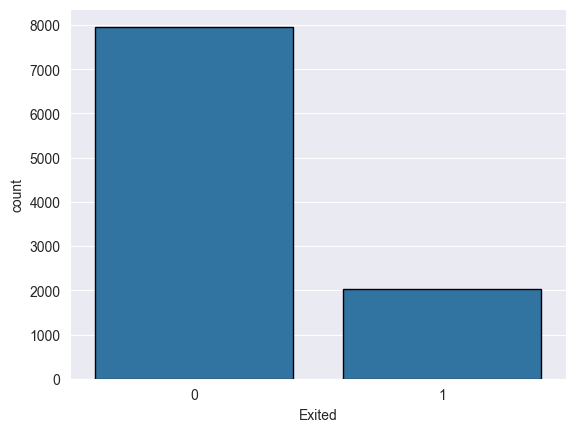

In [525]:
# Visualisasi untuk melihat jumlah masing-masing label pada variabel y
sns.countplot(x='Exited', data=df, edgecolor='black')

### Insights

Dapat dilihat pada visualisasi histogram dibawah, bahwa data cenderung menyebar terutama pada data yang bertipe kategorikal. Sedangkan untuk data numerik cenderung berdistribusi tidak normal. Oleh karena itu, perlu dilakukan analisis lebih lanjut untuk menangani permasalahan ini.

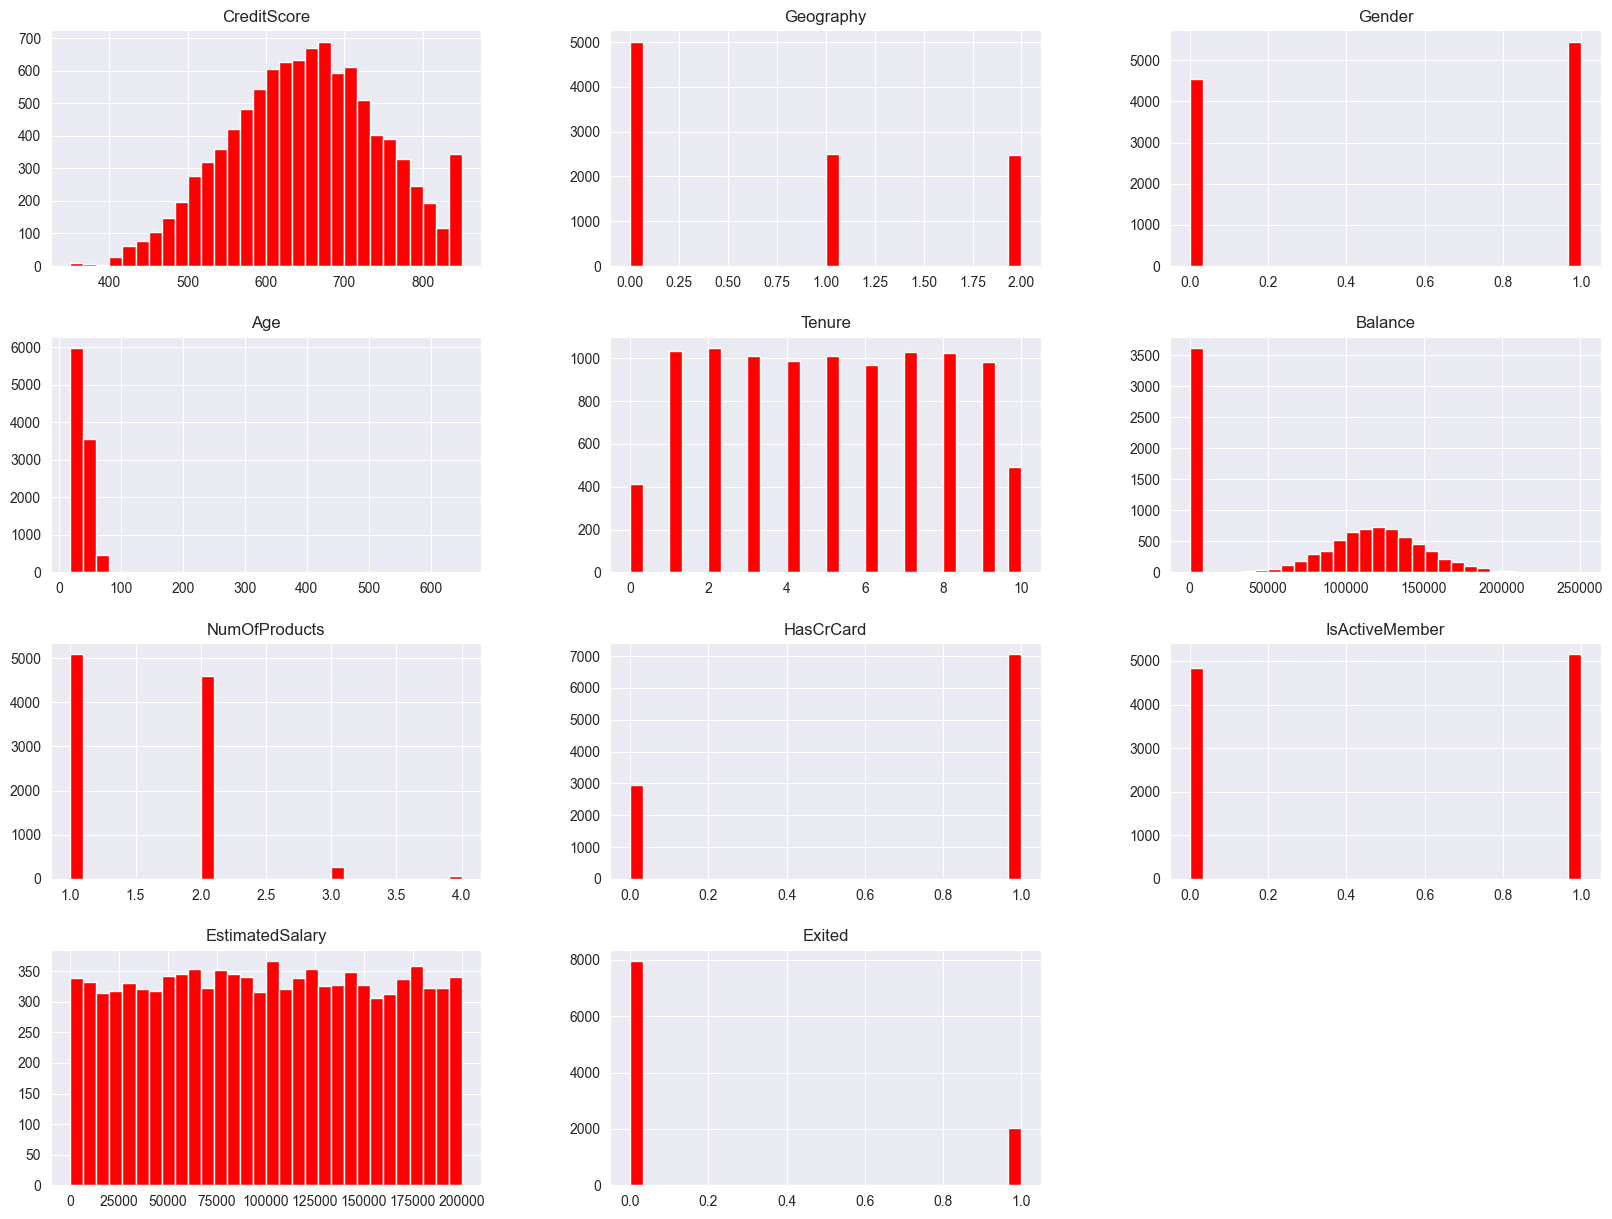

In [526]:
# Visualisasi histogram untuk melihat distribusi data
df.hist(bins = 30, figsize=(20, 15), color = 'red');

### Insights

Dapat dilihat bahwa pada kolom `CreditScore`, `Age`, dan `NumOfProducts` memiliki outlier atau pencilan.

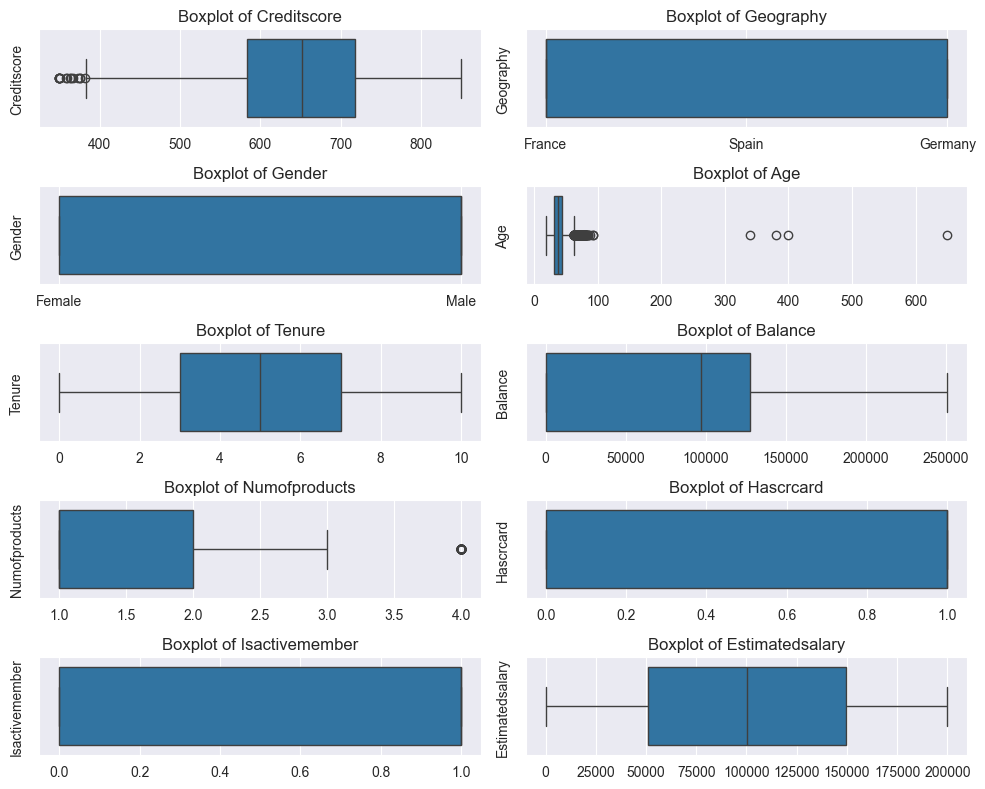

In [527]:
# Visualisasi boxplot untuk melihat outlier pada data
num_features = len(X.columns)
num_rows = (num_features - 1) // 2 + 1
num_cols = min(num_features, 2)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 8))
axes = axes.flatten()

for i, feature in enumerate(X.columns):
    ax = axes[i]

    sns.boxplot(data=X, x=feature, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feature.capitalize())
    ax.set_title(f'Boxplot of {feature.capitalize()}')

for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [528]:
# Menghitung banyaknya outlier pada data
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers.count()

numerical_columns = df.columns[df.dtypes != 'object'] 
columns_to_check = numerical_columns.drop('Exited')  

outlier_counts = df[columns_to_check].apply(count_outliers)

outlier_df = pd.DataFrame({
    'variabel': outlier_counts.index,
    'jumlah outlier': outlier_counts.values
})

outlier_df

,variabel,jumlah outlier
0,CreditScore,15
1,Geography,0
2,Gender,0
3,Age,362
4,Tenure,0
5,Balance,0
6,NumOfProducts,60
7,HasCrCard,0
8,IsActiveMember,0
9,EstimatedSalary,0


### Insights

Dapat dilihat pada visualisasi pairplot dibawah, bahwa data memiliki kecenderungan tidak linear.

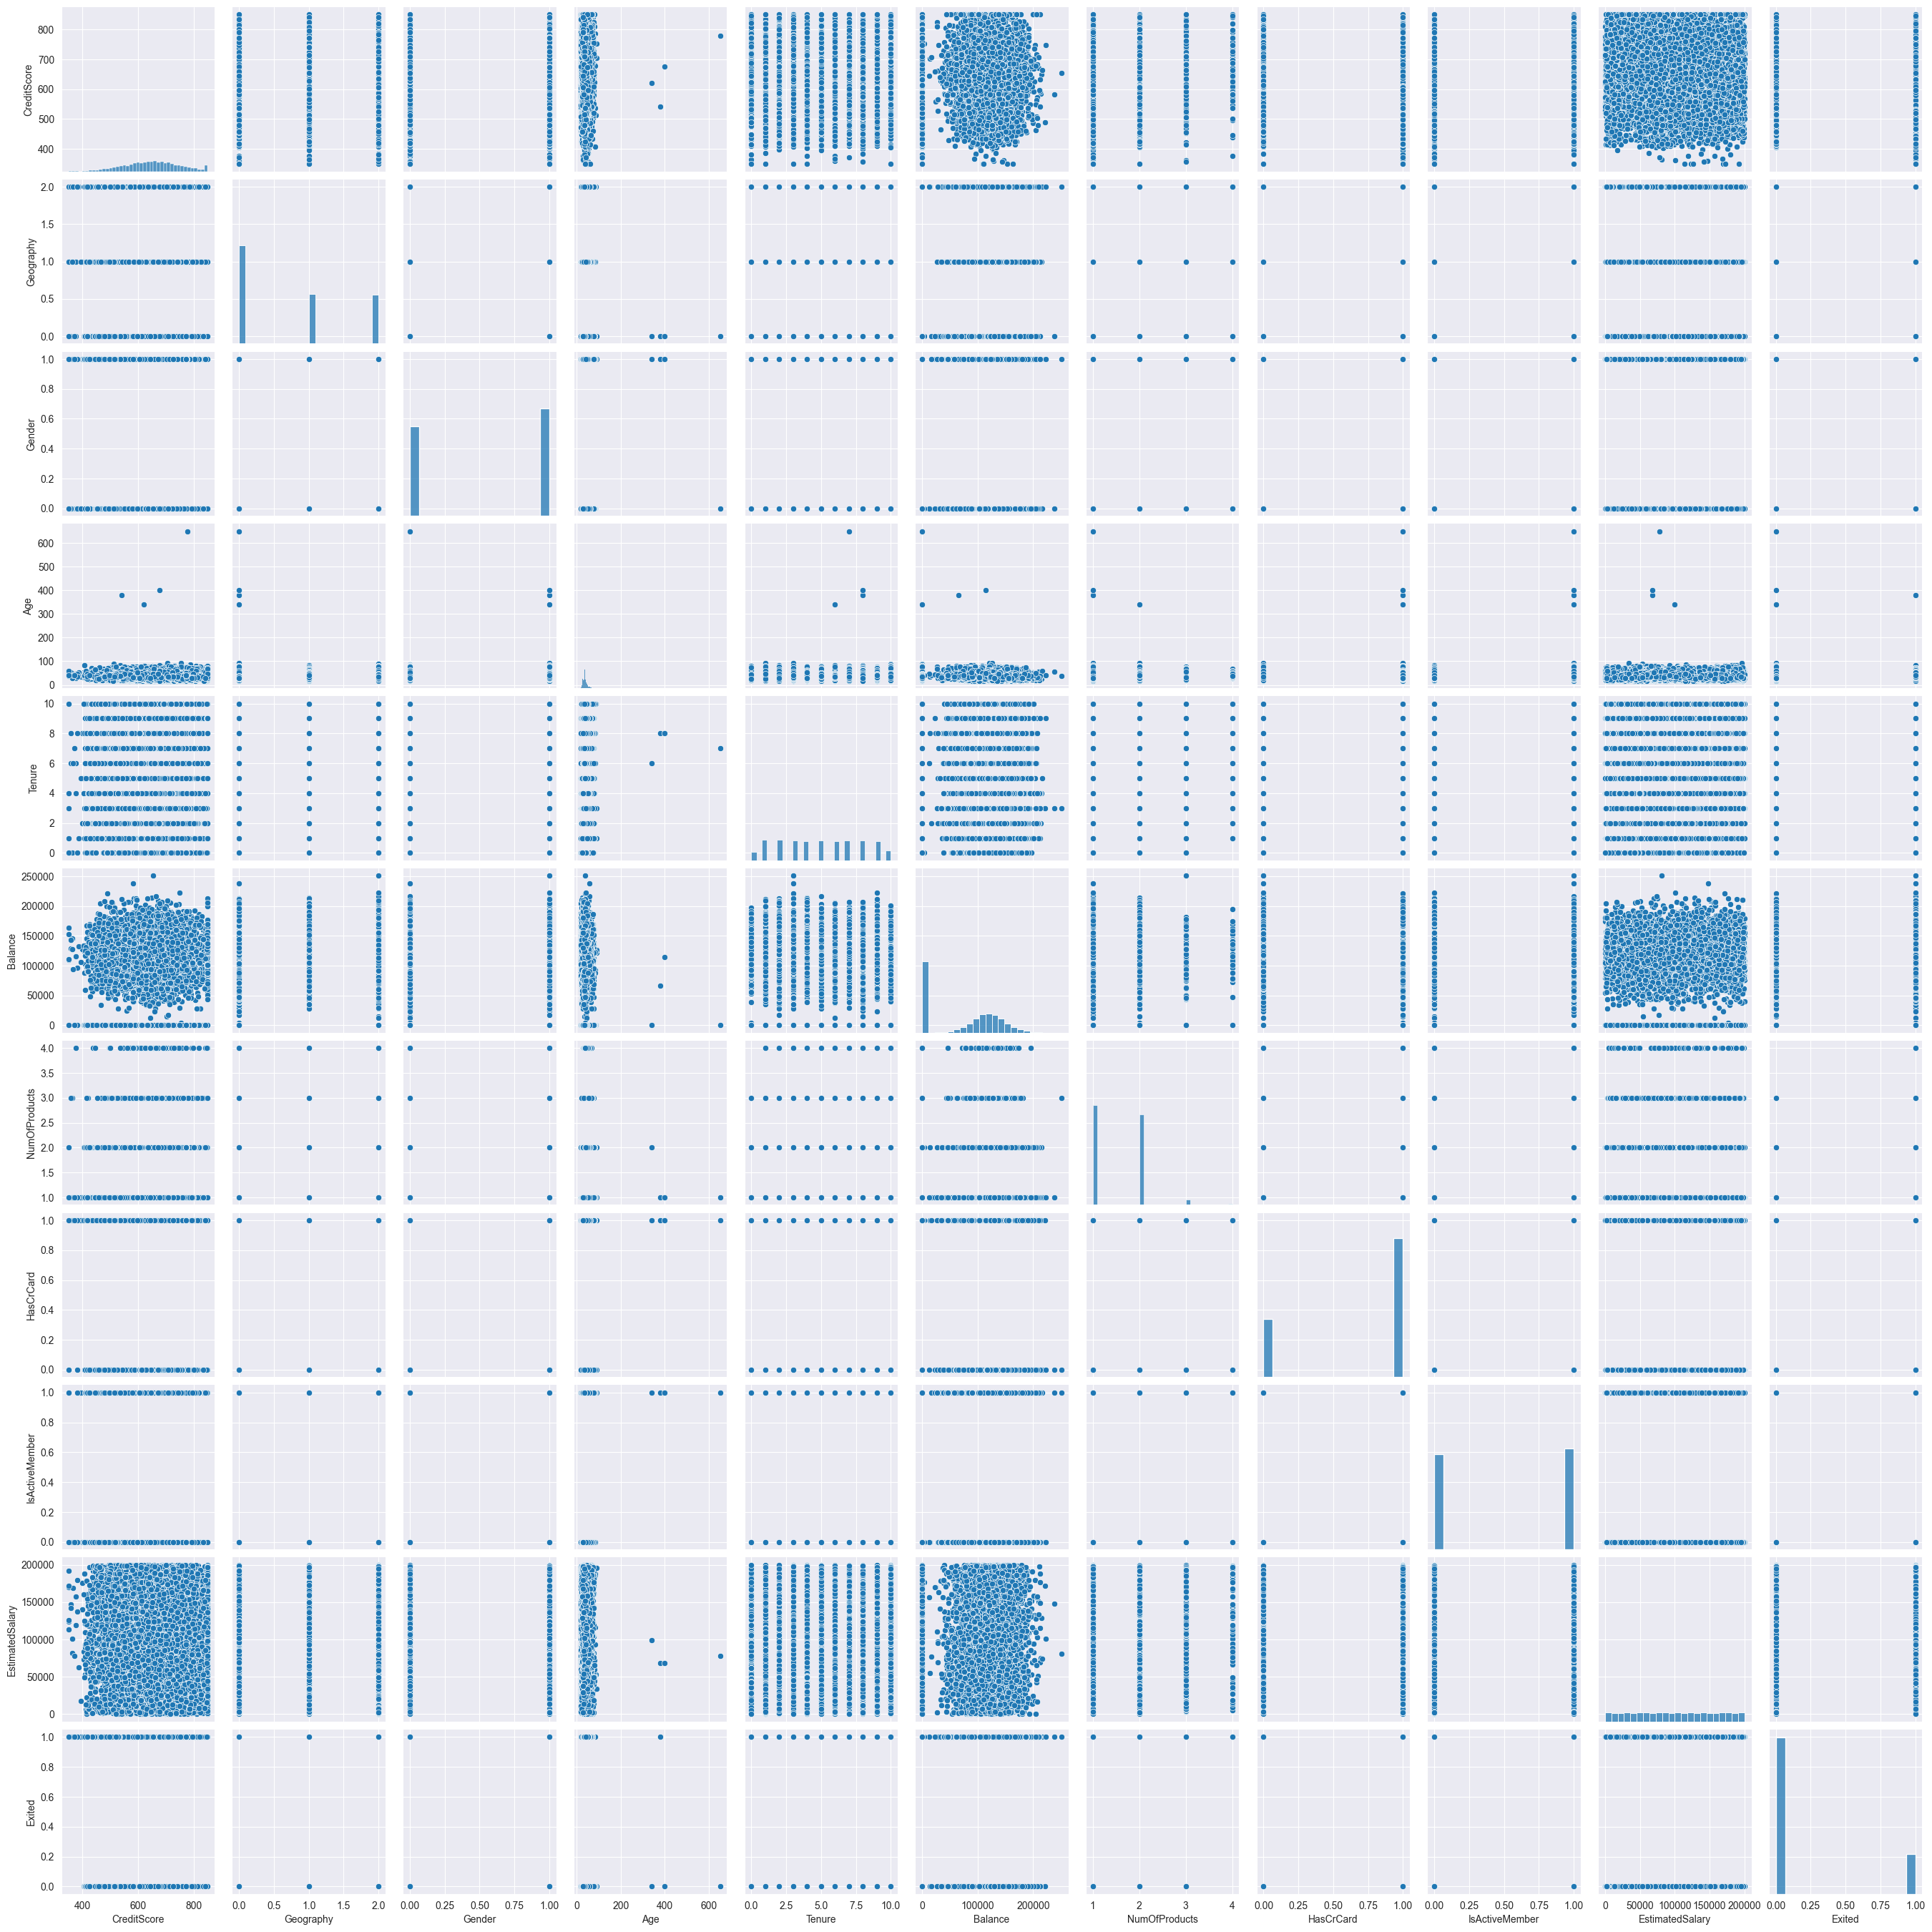

In [529]:
sns.set_style(style='darkgrid')
sns.pairplot(df)

### Insights

Dapat dilihat pada visualisasi heatmap dibawah, fitur yang memiliki korelasi tinggi dengan variabel target yaitu fitur Age.

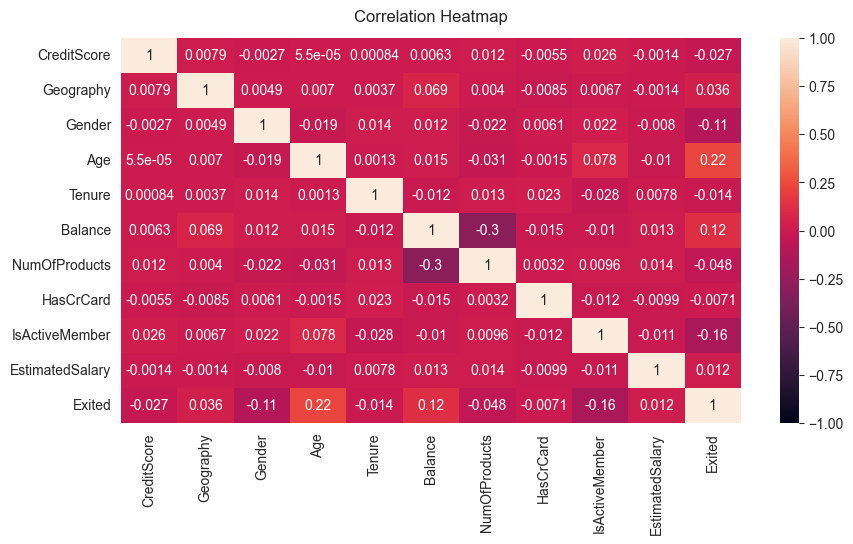

In [530]:
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Preprocessing

In [531]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42.0,2,0.00,1,1,1,101348.88,1
1,608,2,0,41.0,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42.0,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39.0,1,0.00,2,0,0,93826.63,0
4,850,2,0,43.0,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39.0,5,0.00,2,1,0,96270.64,0
9996,516,0,1,35.0,10,57369.61,1,1,1,101699.77,0
9997,709,0,0,36.0,7,0.00,1,0,1,42085.58,1
9998,772,1,1,42.0,3,75075.31,2,1,0,92888.52,1


### Insights

Berdasarkan beberapa kasus yang ditemukan saat EDA, saya memutuskan untuk melakukan transformasi data menggunakan metode BoxCox. Metode BoxCox dipilih karena dapat mengatasi data yang berdistribusi tidak normal, mengurangi dampak outlier, dan membantu memperbaiki linearitas data. Dengan transformasi ini, diharapkan distribusi data menjadi lebih normal, outlier menjadi kurang signifikan, dan hubungan antara variabel menjadi lebih linear, yang dapat meningkatkan kinerja model machine learning.

In [532]:
# Transformasi BoxCox pada data numerik
df_copy = df.copy()

# Menambah konstanta untuk menghindari nilai nol atau negatif
constant = 1

columns_to_transform = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

for column in columns_to_transform:
    adjusted_data = df_copy[column] + constant
    df_copy[column + '_transformed'], lambda_value = boxcox(adjusted_data)

df_copy.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_transformed,Age_transformed,Tenure_transformed,Balance_transformed,NumOfProducts_transformed,EstimatedSalary_transformed
0,619,0,0,42.0,2,0.00,1,1,1,101348.88,1,1258.915175,1.939871,1.700065,0.000000,0.468974,5153.408249
1,608,2,0,41.0,1,83807.86,1,0,1,112542.58,0,1233.706040,1.934653,0.907144,28.900281,0.468974,5552.683567
2,502,0,0,42.0,8,159660.80,3,1,0,113931.57,1,993.940938,1.939871,5.551622,32.417999,0.671470,5601.411598
3,699,0,0,39.0,1,0.00,2,0,0,93826.63,0,1443.941179,1.923676,0.907144,0.000000,0.607300,4877.946664
4,850,2,0,43.0,2,125510.82,1,1,1,79084.10,0,1800.489499,1.944921,1.700065,31.065767,0.468974,4318.724921


In [533]:
# Memilih kolom yang telah ditransformasi untuk digunakan pada tahap modeling 
columns_to_select = ['CreditScore_transformed', 'Geography', 'Gender', 'Age_transformed', 'Tenure_transformed', 'Balance_transformed', 'NumOfProducts_transformed', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary_transformed', 'Exited']
df_copy = df_copy[columns_to_select]

df_copy.head()

,CreditScore_transformed,Geography,Gender,Age_transformed,Tenure_transformed,Balance_transformed,NumOfProducts_transformed,HasCrCard,IsActiveMember,EstimatedSalary_transformed,Exited
0,1258.915175,0,0,1.939871,1.700065,0.000000,0.468974,1,1,5153.408249,1
1,1233.706040,2,0,1.934653,0.907144,28.900281,0.468974,0,1,5552.683567,0
2,993.940938,0,0,1.939871,5.551622,32.417999,0.671470,1,0,5601.411598,1
3,1443.941179,0,0,1.923676,0.907144,0.000000,0.607300,0,0,4877.946664,0
4,1800.489499,2,0,1.944921,1.700065,31.065767,0.468974,1,1,4318.724921,0


### Insights

Setelah dilakukan transformasi BoxCox, outlier pada data berkurang namun masih terdapat sedikit outlier pada data. Pada kasus ini, saya memutuskan untuk membuang outlier dikarenakan jumlah outlier terbilang cukup sedikit dengan perbandingan data keseluruhan.

In [534]:
# Menghitung banyaknya outlier setelah dilakukan transformasi
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers.count()

numerical_columns = df_copy.columns[df.dtypes != 'object']  
columns_to_check = numerical_columns.drop('Exited')

outlier_counts = df_copy[columns_to_check].apply(count_outliers)

outlier_df = pd.DataFrame({
    'variabel': outlier_counts.index,
    'jumlah outlier': outlier_counts.values
})

outlier_df

,variabel,jumlah outlier
0,CreditScore_transformed,12
1,Geography,0
2,Gender,0
3,Age_transformed,170
4,Tenure_transformed,0
5,Balance_transformed,0
6,NumOfProducts_transformed,0
7,HasCrCard,0
8,IsActiveMember,0
9,EstimatedSalary_transformed,0


In [535]:
# Menghapus data yang memiliki outlier

columns_to_check = ['CreditScore_transformed', 'Age_transformed']

for column in columns_to_check:
    Q1 = df_copy[column].quantile(0.25)
    Q3 = df_copy[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_copy = df_copy[(df_copy[column] >= lower_bound) & (df_copy[column] <= upper_bound)]

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9818 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CreditScore_transformed      9818 non-null   float64
 1   Geography                    9818 non-null   int64  
 2   Gender                       9818 non-null   int64  
 3   Age_transformed              9818 non-null   float64
 4   Tenure_transformed           9818 non-null   float64
 5   Balance_transformed          9818 non-null   float64
 6   NumOfProducts_transformed    9818 non-null   float64
 7   HasCrCard                    9818 non-null   int64  
 8   IsActiveMember               9818 non-null   int64  
 9   EstimatedSalary_transformed  9818 non-null   float64
 10  Exited                       9818 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 920.4 KB


### Insights

Data yang akan digunakan pada tahap modeling yaitu sebanyak 9818 baris dan 10 kolom untuk variabel X dengan 1 kolom untuk variabel y. Data tersebut memiliki tipe data numerik sehingga memudahkan proses pemodelan.

In [536]:
# Mendeklarasikan variabel X dan y setelah dilakukan beberapa perlakuan terhadap data
X = df_copy.drop(columns='Exited')
y = df_copy['Exited']

In [537]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9818 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CreditScore_transformed      9818 non-null   float64
 1   Geography                    9818 non-null   int64  
 2   Gender                       9818 non-null   int64  
 3   Age_transformed              9818 non-null   float64
 4   Tenure_transformed           9818 non-null   float64
 5   Balance_transformed          9818 non-null   float64
 6   NumOfProducts_transformed    9818 non-null   float64
 7   HasCrCard                    9818 non-null   int64  
 8   IsActiveMember               9818 non-null   int64  
 9   EstimatedSalary_transformed  9818 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 843.7 KB


In [538]:
y.info()

<class 'pandas.core.series.Series'>
Index: 9818 entries, 0 to 9999
Series name: Exited
Non-Null Count  Dtype
--------------  -----
9818 non-null   int64
dtypes: int64(1)
memory usage: 153.4 KB


In [539]:
df_copy

,CreditScore_transformed,Geography,Gender,Age_transformed,Tenure_transformed,Balance_transformed,NumOfProducts_transformed,HasCrCard,IsActiveMember,EstimatedSalary_transformed,Exited
0,1258.915175,0,0,1.939871,1.700065,0.000000,0.468974,1,1,5153.408249,1
1,1233.706040,2,0,1.934653,0.907144,28.900281,0.468974,0,1,5552.683567,0
2,993.940938,0,0,1.939871,5.551622,32.417999,0.671470,1,0,5601.411598,1
3,1443.941179,0,0,1.923676,0.907144,0.000000,0.607300,0,0,4877.946664,0
4,1800.489499,2,0,1.944921,1.700065,31.065767,0.468974,1,1,4318.724921,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1612.829405,0,1,1.923676,3.755232,0.000000,0.607300,1,0,4968.119721,0
9996,1025.262014,0,1,1.899225,6.662500,26.980629,0.468974,1,1,5166.111074,0
9997,1467.268890,0,0,1.905683,4.972828,0.000000,0.468974,0,1,2755.422830,1
9998,1615.189890,1,1,1.939871,2.426866,28.332016,0.607300,1,0,4843.155564,1


### Insights

Pada tahap spliting, saya membagi data menjadi 2 bagian, yaitu data train untuk melatih model dan data test untuk menguji model dengan proporsi data test sebesar 20% dari total data.

In [444]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Modeling & Evaluation

## Decision Tree

### Insights

- Saya menerapkan hyperparameter tuning untuk mencari nilai parameter yang sesuai dalam menghasilkan akurasi yang optimal. Pada kasus ini saya memilih Optuna dikarenakan Optuna menawarkan pencarian parameter yang lebih efisien dan adaptif, karena menggunakan algoritma berbasis Bayesian Optimization. Dengan demikian, Optuna dapat menemukan kombinasi parameter terbaik lebih cepat dan akurat, terutama dalam ruang parameter yang besar dan kompleks.
- Setelah dilakukan prediksi menggunakan model Decision Tree yang telah dibangun, model memiliki akurasi yang terbilang cukup dalam mengklasifikasikan data tersebut. Namun precision, recall, dan f1-score pada model terbilang memiliki rentang nilai yang cukup jauh antara kelas 0 dan 1 yang menandakan bahwa model cenderung lebih baik dalam memprediksi salah satu kelas, tetapi kurang akurat dalam memprediksi kelas lainnya. Ketidakseimbangan ini bisa disebabkan oleh ketidakseimbangan data seperti yang telah diketahui pada tahap EDA sehingga perlu dilakukan suatu teknik, seperti resampling data untuk meningkatkan performa pada kedua kelas.

In [445]:
# Hyperparameter Tuning with Optuna
def tuning(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(tuning, n_trials=100)

print(f"Best Score: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

[I 2024-08-21 15:53:25,017] A new study created in memory with name: no-name-5f168e44-d877-42c5-ad0f-51ecff033e86
[I 2024-08-21 15:53:25,049] Trial 0 finished with value: 0.8335030549898167 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.8335030549898167.
[I 2024-08-21 15:53:25,071] Trial 1 finished with value: 0.8411405295315683 and parameters: {'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 1 with value: 0.8411405295315683.
[I 2024-08-21 15:53:25,097] Trial 2 finished with value: 0.8528513238289206 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 2 with value: 0.8528513238289206.
[I 2024-08-21 15:53:25,126] Trial 3 finished with value: 0.7988798370672098 and parameters: {'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 2 with value

Best Score: 0.8538696537678208
Best Parameters: {'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 9, 'criterion': 'gini'}


In [451]:
dtc = DecisionTreeClassifier(max_depth= 7,
                             min_samples_split= 12,
                             min_samples_leaf= 9,
                             criterion= 'gini')

dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=9, min_samples_split=12)

In [447]:
dtc_pred = dtc.predict(X_test)
print(classification_report(y_test, dtc_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1561
           1       0.78      0.40      0.53       403

    accuracy                           0.85      1964
   macro avg       0.82      0.69      0.72      1964
weighted avg       0.85      0.85      0.83      1964



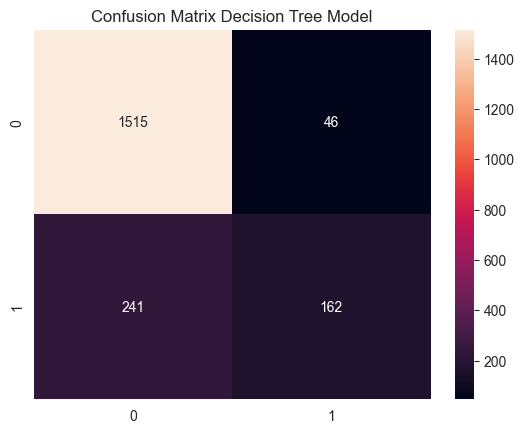

In [448]:
cm_dtc = confusion_matrix(y_test, dtc_pred)
sns.heatmap(cm_dtc, annot=True, fmt='.0f')
plt.title('Confusion Matrix Decision Tree Model')
plt.show()

## Random Forest

### Insights

- Di sini, saya memilih algoritma Random Forest karena algoritma ini menawarkan beberapa keunggulan, terutama dalam menangani dataset yang kompleks dan memiliki banyak fitur. Random Forest merupakan ensemble method yang menggabungkan prediksi dari banyak decision trees, sehingga mampu meningkatkan akurasi dan mengurangi overfitting dibandingkan dengan model decision tree tunggal. Algoritma ini juga robust terhadap data yang memiliki missing values dan outliers serta mampu menangani data dengan variabel input yang bersifat numerik maupun kategorikal. Selain itu, Random Forest memberikan estimasi mengenai fitur mana yang paling penting dalam memprediksi target, yang dapat membantu dalam interpretasi model.
- Metode Hyperparameter Tuning yang digunakan sama dengan Hyperparameter Tuning pada model sebelumnya, yaitu Optuna.
- Setelah dilakukan prediksi menggunakan model Random Forest yang telah dibangun, kesimpulan yang didapat kurang lebih sama dengan modeling sebelumnya, sehingga saya memutuskan untuk melakukan resampling pada data dengan harapan apat meningkatkan performa model dalam memprediksi kedua kelas tersebut.

In [449]:
#Hyperparameter Tuning with Optuna
def tuning(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    model = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=42
                                 )

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')  
study.optimize(tuning, n_trials=50) 

print('Best hyperparameters: ', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2024-08-21 16:06:51,788] A new study created in memory with name: no-name-382fb9cc-aa32-410b-86ed-d8df808fec1c


[I 2024-08-21 16:06:52,247] Trial 0 finished with value: 0.844704684317719 and parameters: {'n_estimators': 91, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 0 with value: 0.844704684317719.
[I 2024-08-21 16:06:52,954] Trial 1 finished with value: 0.845213849287169 and parameters: {'n_estimators': 128, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.845213849287169.
[I 2024-08-21 16:06:53,554] Trial 2 finished with value: 0.8426680244399185 and parameters: {'n_estimators': 114, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.845213849287169.
[I 2024-08-21 16:06:54,476] Trial 3 finished with value: 0.844704684317719 and parameters: {'n_estimators': 160, 'max_depth': 30, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.845213849287169.

Best hyperparameters:  {'n_estimators': 126, 'max_depth': 50, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'log2'}
Best accuracy:  0.8492871690427699


In [452]:
rfc = RandomForestClassifier(n_estimators= 126,
                             max_depth= 50,
                             min_samples_split= 20,
                             min_samples_leaf= 6,
                             max_features= 'log2')

rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, max_features='log2', min_samples_leaf=6,
                       min_samples_split=20, n_estimators=126)

In [453]:
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1561
           1       0.73      0.38      0.50       403

    accuracy                           0.85      1964
   macro avg       0.80      0.67      0.71      1964
weighted avg       0.83      0.85      0.83      1964



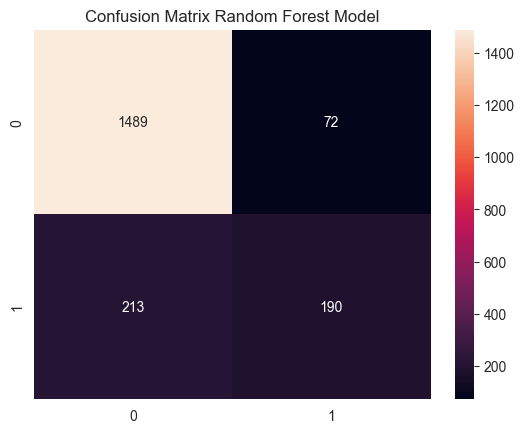

In [377]:
cm_rfc = confusion_matrix(y_test, rfc_pred)
sns.heatmap(cm_rfc, annot=True, fmt='.0f')
plt.title('Confusion Matrix Random Forest Model')
plt.show()

# Resampling and Modeling

## Oversampling

### Insights

- Pada kasus ini, saya memutuskan untuk menerapkan oversampling menggunakan SMOTE dikarenakan efektif dalam menangani masalah ketidakseimbangan kelas dengan cara menghasilkan contoh sintetis untuk kelas minoritas. Metode ini bekerja dengan membuat data baru yang mirip dengan data minoritas yang ada, sehingga memperkaya dataset dan memungkinkan model untuk belajar lebih baik dari data minoritas. SMOTE membantu dalam meningkatkan performa model dalam mendeteksi kelas minoritas yang biasanya terabaikan dalam data yang tidak seimbang. Hal tersebut dapat membantu dalam mengurangi bias dan meningkatkan akurasi serta metrik evaluasi lainnya seperti recall dan f1-score untuk kelas minoritas.
- Adapun total data setelah dilakukan oversampling yaitu sebanyak 15606 data dengan kelas 0 dan 1 pada kolom `Exited` yang sudah seimbang

In [454]:
smote = SMOTE(random_state=42)
X_ovs, y_ovs = smote.fit_resample(X, y)

<Axes: xlabel='Exited', ylabel='count'>

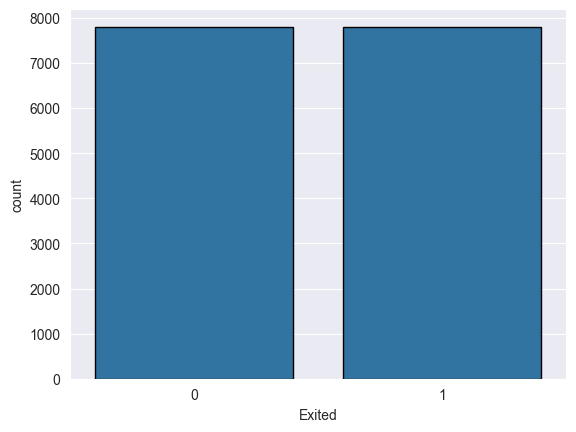

In [455]:
# Visualisasi data y setelah oversampling
sns.countplot(x='Exited', data=pd.DataFrame(y_ovs), edgecolor='black')

In [456]:
X_ovs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15606 entries, 0 to 15605
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CreditScore_transformed      15606 non-null  float64
 1   Geography                    15606 non-null  int64  
 2   Gender                       15606 non-null  int64  
 3   Age_transformed              15606 non-null  float64
 4   Tenure_transformed           15606 non-null  float64
 5   Balance_transformed          15606 non-null  float64
 6   NumOfProducts_transformed    15606 non-null  float64
 7   HasCrCard                    15606 non-null  int64  
 8   IsActiveMember               15606 non-null  int64  
 9   EstimatedSalary_transformed  15606 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 1.2 MB


In [457]:
y_ovs.info()

<class 'pandas.core.series.Series'>
RangeIndex: 15606 entries, 0 to 15605
Series name: Exited
Non-Null Count  Dtype
--------------  -----
15606 non-null  int64
dtypes: int64(1)
memory usage: 122.1 KB


### Insights

Pada tahap spliting, saya membagi data menjadi 2 bagian, yaitu data train untuk melatih model dan data test untuk menguji model dengan proporsi data test sebesar 25% dari total data.

In [471]:
X_train_ovs, X_test_ovs, y_train_ovs, y_test_ovs = train_test_split(X_ovs, y_ovs, test_size=0.25, stratify=y_ovs)

## Decision Tree with Oversampling

### Insights

Dapat dilihat pada classification report, bahwa model Decision Tree sudah dapat dikatakan cukup optimal dalam mengklasifikasikan data yang dibuktikan dengan nilai akurasinya sebesar 87% ketika diujikan pada data test. Selain itu precision, recall, dan f1-score pada model ini juga sudah cukup baik, sehingga model sudah cukup seimbang dalam mengklasifikasikan kelas 0 maupun 1.

In [459]:
def tuning(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )

    model.fit(X_train_ovs, y_train_ovs)

    y_pred = model.predict(X_test_ovs)
    accuracy = accuracy_score(y_test_ovs, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(tuning, n_trials=100)

print(f"Best Score: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

[I 2024-08-21 16:16:27,192] A new study created in memory with name: no-name-1d3e0d2f-a54d-4cdd-856f-92f5fc25471d
[I 2024-08-21 16:16:27,260] Trial 0 finished with value: 0.8600717580727832 and parameters: {'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.8600717580727832.
[I 2024-08-21 16:16:27,293] Trial 1 finished with value: 0.8426447975397232 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8600717580727832.
[I 2024-08-21 16:16:27,323] Trial 2 finished with value: 0.8587903639159405 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.8600717580727832.
[I 2024-08-21 16:16:27,346] Trial 3 finished with value: 0.8172731932342389 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 0 with 

Best Score: 0.8713480266529985
Best Parameters: {'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 20, 'criterion': 'entropy'}


In [460]:
dtc = DecisionTreeClassifier(max_depth= 12,
                             min_samples_split= 15,
                             min_samples_leaf= 20,
                             criterion= 'entropy')

dtc.fit(X_train_ovs,y_train_ovs)

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=20,
                       min_samples_split=15)

In [461]:
# Prediksi Data Train

dtc_pred_ovs = dtc.predict(X_train_ovs)
print(classification_report(y_train_ovs, dtc_pred_ovs))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      5852
           1       0.91      0.86      0.88      5852

    accuracy                           0.89     11704
   macro avg       0.89      0.89      0.89     11704
weighted avg       0.89      0.89      0.89     11704



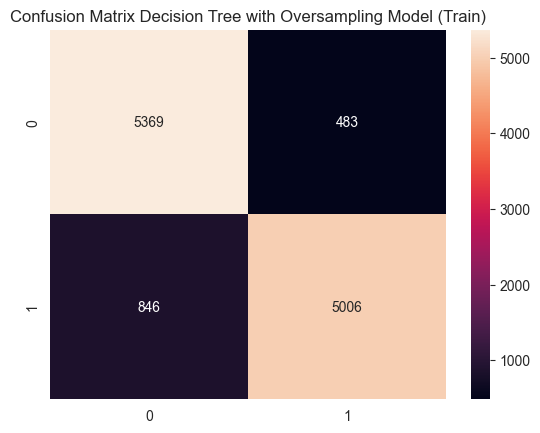

In [462]:
cm_dtc = confusion_matrix(y_train_ovs, dtc_pred_ovs)
sns.heatmap(cm_dtc, annot=True, fmt='.0f')
plt.title('Confusion Matrix Decision Tree with Oversampling Model (Train)')
plt.show()

In [463]:
# Prediksi Data Test

dtc_pred_ovs = dtc.predict(X_test_ovs)
print(classification_report(y_test_ovs, dtc_pred_ovs))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1951
           1       0.90      0.84      0.87      1951

    accuracy                           0.87      3902
   macro avg       0.87      0.87      0.87      3902
weighted avg       0.87      0.87      0.87      3902



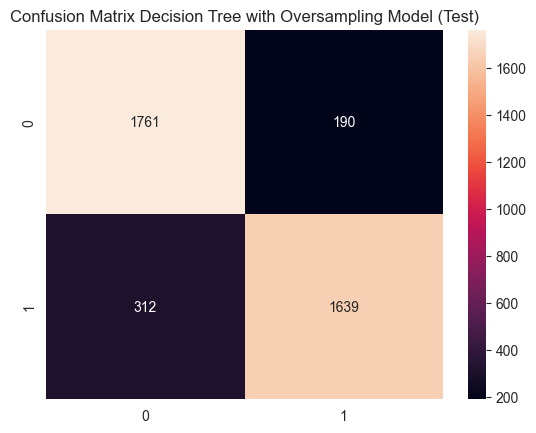

In [464]:
cm_dtc = confusion_matrix(y_test_ovs, dtc_pred_ovs)
sns.heatmap(cm_dtc, annot=True, fmt='.0f')
plt.title('Confusion Matrix Decision Tree with Oversampling Model (Test)')
plt.show()

## Random Forest with Oversampling

### Insights

Dapat dilihat pada classification report, bahwa model Random Forest sudah dapat dikatakan cukup optimal dalam mengklasifikasikan data yang dibuktikan dengan nilai akurasinya sebesar 88% ketika diujikan pada data test, dimana nilai tersebut juga lebih tinggi dibandingkan akurasi pada model Decision Tree. Selain itu precision, recall, dan f1-score pada model ini juga sudah cukup baik, sehingga model sudah cukup seimbang dalam mengklasifikasikan kelas 0 maupun 1.

In [472]:
def tuning(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    model = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=42)

    model.fit(X_train_ovs, y_train_ovs)
    
    y_pred = model.predict(X_test_ovs)
    
    accuracy = accuracy_score(y_test_ovs, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')  
study.optimize(tuning, n_trials=50) 

print('Best hyperparameters: ', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2024-08-21 16:21:57,330] A new study created in memory with name: no-name-b4fc2192-53b0-4cc2-b19c-34b1730829f2
[I 2024-08-21 16:21:58,950] Trial 0 finished with value: 0.8792926704254228 and parameters: {'n_estimators': 156, 'max_depth': 36, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8792926704254228.
[I 2024-08-21 16:21:59,480] Trial 1 finished with value: 0.867247565351102 and parameters: {'n_estimators': 68, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 0 with value: 0.8792926704254228.
[I 2024-08-21 16:22:01,260] Trial 2 finished with value: 0.8774987186058432 and parameters: {'n_estimators': 167, 'max_depth': 40, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.8792926704254228.
[I 2024-08-21 16:22:02,744] Trial 3 finished with value: 0.8754484879548949 and parameters: {'n_estimators': 151, 'max_depth': 22, '

Best hyperparameters:  {'n_estimators': 91, 'max_depth': 32, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best accuracy:  0.8844182470527935


In [473]:
rfc = RandomForestClassifier(n_estimators= 91,
                             max_depth= 32,
                             min_samples_split= 12,
                             min_samples_leaf= 1,
                             max_features= 'sqrt')

rfc.fit(X_train_ovs,y_train_ovs)

RandomForestClassifier(max_depth=32, min_samples_split=12, n_estimators=91)

In [474]:
# Prediksi Data Train

rfc_pred_ovs = rfc.predict(X_train_ovs)
print(classification_report(y_train_ovs, rfc_pred_ovs))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      5852
           1       0.97      0.94      0.95      5852

    accuracy                           0.96     11704
   macro avg       0.96      0.96      0.96     11704
weighted avg       0.96      0.96      0.96     11704



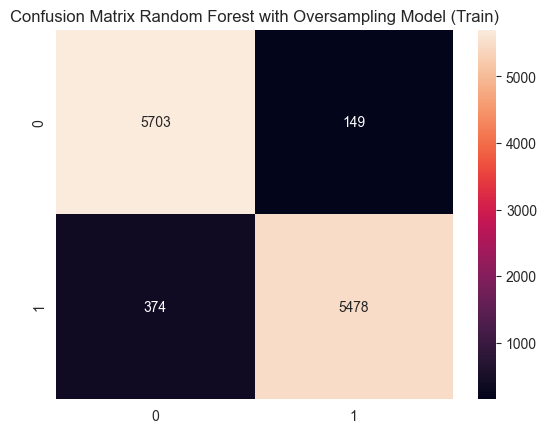

In [475]:
cm_rfc = confusion_matrix(y_train_ovs, rfc_pred_ovs)
sns.heatmap(cm_rfc, annot=True, fmt='.0f')
plt.title('Confusion Matrix Random Forest with Oversampling Model (Train)')
plt.show()

In [476]:
# Prediksi Data Test

rfc_pred_ovs = rfc.predict(X_test_ovs)
print(classification_report(y_test_ovs, rfc_pred_ovs))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1951
           1       0.91      0.85      0.88      1951

    accuracy                           0.88      3902
   macro avg       0.89      0.88      0.88      3902
weighted avg       0.89      0.88      0.88      3902



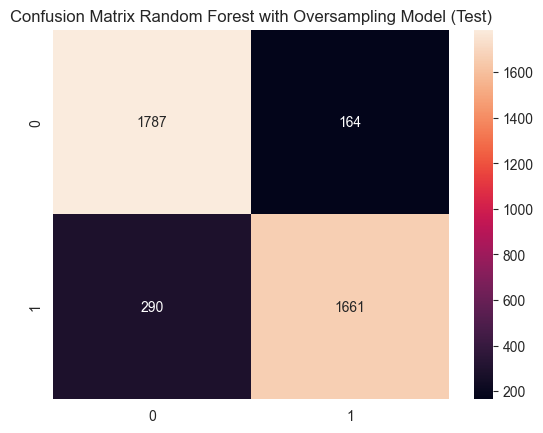

In [477]:
cm_rfc = confusion_matrix(y_test_ovs, rfc_pred_ovs)
sns.heatmap(cm_rfc, annot=True, fmt='.0f')
plt.title('Confusion Matrix Random Forest with Oversampling Model (Test)')
plt.show()

# Feature Importance

### Insights

Berdasarkan feature importance dengan algoritma Random Forest, didapatkan hasil bahwa fitur Age menjadi fitur yang paling berpengaruh terhadap hasil prediksi fitur target yang kemudian disusul oleh fitur NumOfProducts, Balance, IsActiveMember, EstimatedSalary, CreditScore, Gender, Tenure, Geography, dan HasCrCard yang menjadi fitur dengan pengaruh paling rendah terhadap hasil prediksi fitur target.

In [478]:
fi = pd.Series(rfc.feature_importances_,index=X_ovs.columns).sort_values(ascending=False)
fi

Age_transformed                0.240917
NumOfProducts_transformed      0.233329
Balance_transformed            0.122644
IsActiveMember                 0.119265
Gender                         0.078505
EstimatedSalary_transformed    0.055793
CreditScore_transformed        0.051214
Tenure_transformed             0.044606
Geography                      0.041462
HasCrCard                      0.012264
dtype: float64

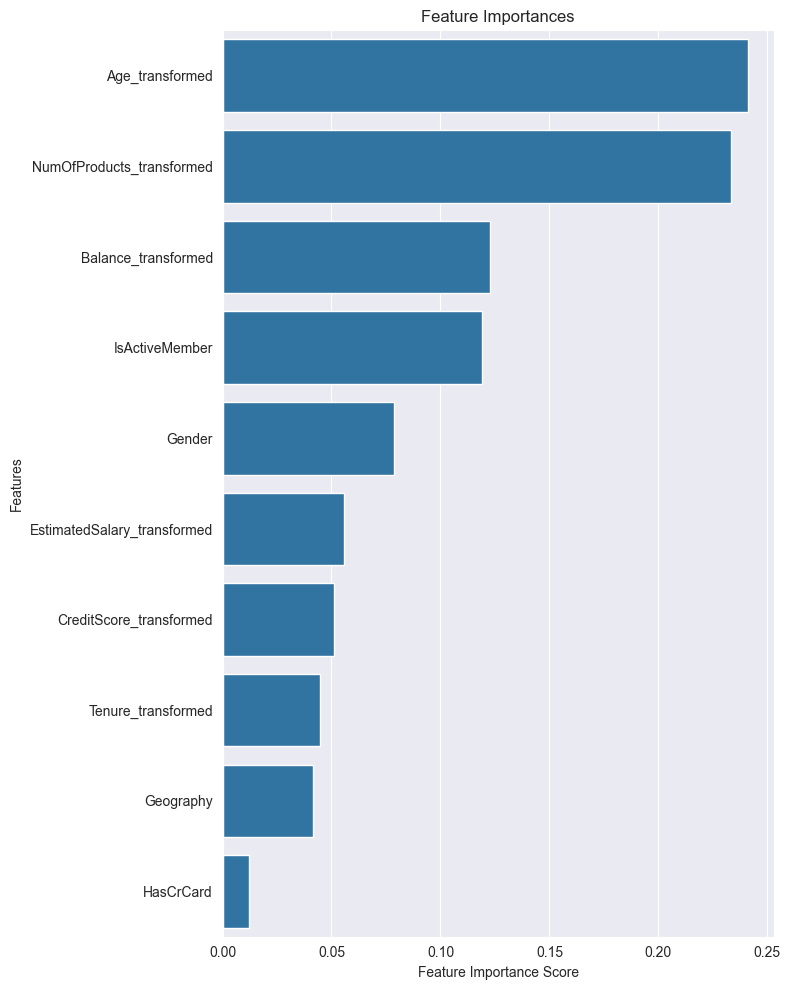

In [479]:
plt.figure(figsize=(8,10))
sns.barplot(x=fi, y=fi.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importances")

plt.tight_layout()
plt.show()